In [209]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [210]:
df = pd.read_excel("premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [211]:
df.shape

(50000, 13)

In [212]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [213]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [214]:
# as the dataset is of 50k values we can drop them as it can not be that much efficient

In [215]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [216]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [217]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [218]:
df[df.number_of_dependants < 0]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
402,23,Female,Southwest,Unmarried,-3,Underweight,No Smoking,Freelancer,10L - 25L,18,No Disease,Silver,9309
2245,18,Male,Southwest,Unmarried,-3,Overweight,No Smoking,Freelancer,25L - 40L,28,No Disease,Silver,8095
2323,19,Male,Northwest,Unmarried,-3,Underweight,No Smoking,Freelancer,25L - 40L,40,No Disease,Bronze,4641
2986,34,Female,Southeast,Married,-1,Underweight,Regular,Self-Employed,25L - 40L,35,High blood pressure & Heart disease,Silver,22995
3756,41,Male,Southwest,Married,-1,Obesity,Regular,Salaried,10L - 25L,21,Diabetes,Silver,22766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48062,23,Male,Northwest,Unmarried,-1,Normal,No Smoking,Freelancer,> 40L,54,No Disease,Gold,13601
48086,36,Female,Southwest,Married,-1,Obesity,Occasional,Salaried,<10L,3,Diabetes,Bronze,14422
49256,60,Female,Southwest,Married,-1,Normal,No Smoking,Self-Employed,10L - 25L,21,Thyroid,Bronze,10141
49270,34,Male,Southeast,Married,-1,Obesity,No Smoking,Self-Employed,10L - 25L,17,Diabetes & Thyroid,Silver,21816


In [219]:
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-3, -1])

In [220]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

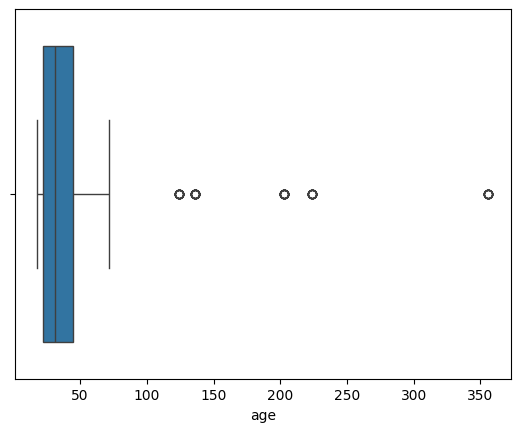

In [221]:
sns.boxplot(x=df["age"])
plt.show()

In [222]:
df.select_dtypes(["float64","int64"])

,age,number_of_dependants,income_lakhs,annual_premium_amount
0,26,0,6,9053
1,29,2,6,16339
2,49,2,20,18164
3,30,3,77,20303
4,18,0,99,13365
...,...,...,...,...
49995,24,0,35,9111
49996,47,2,82,27076
49997,21,0,32,8564
49998,18,2,20,9490


In [223]:
numeric_features = df.select_dtypes(["float64","int64"]).columns
numeric_features

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

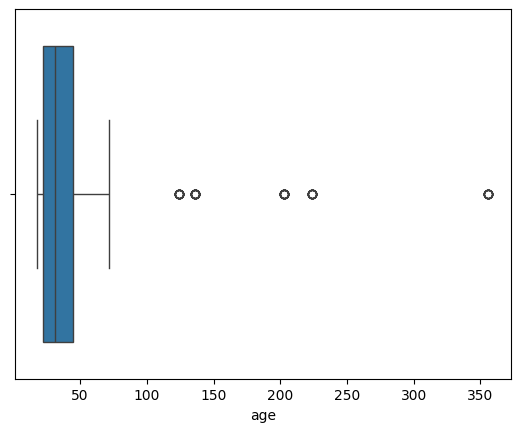

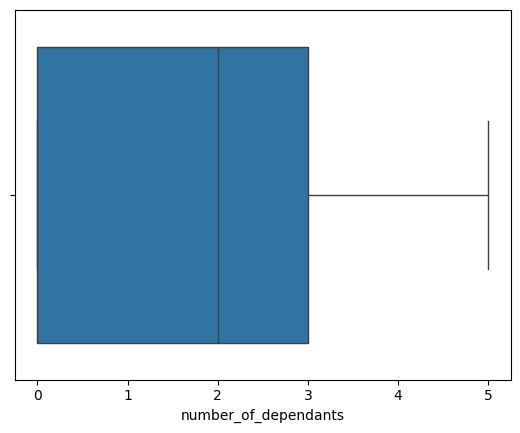

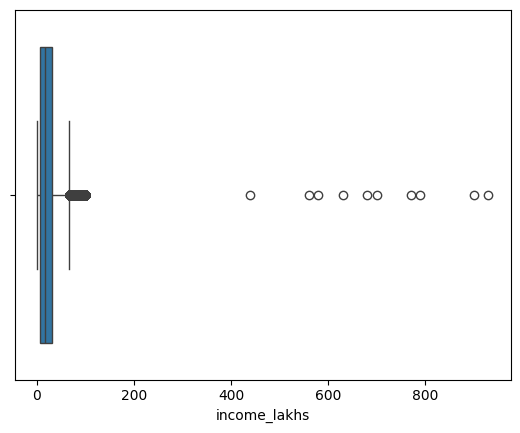

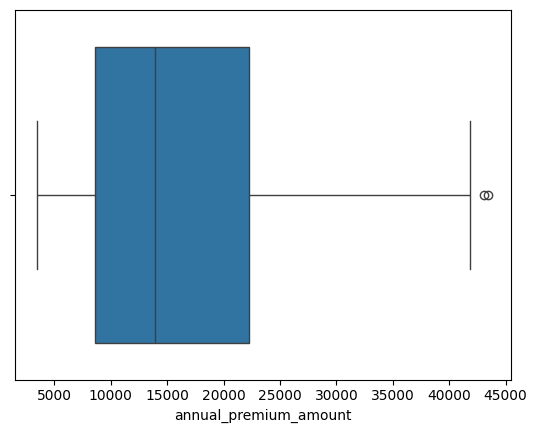

In [224]:
for col in numeric_features :
    sns.boxplot(x=df[col])
    plt.show()

In [225]:
df[df["age"]>100]["age"].unique()

array([224, 124, 136, 203, 356])

In [226]:
df[df["age"]>100]["age"].shape

(58,)

In [227]:
# 58 is less so we can drop then instead of giving mean median mode

In [228]:
df1 = df[df["age"]<=100].copy()
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [229]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

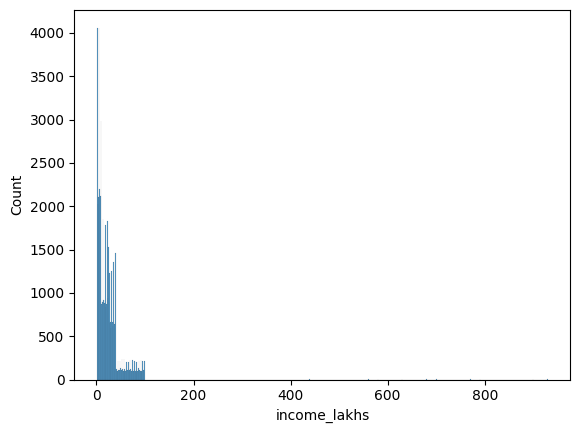

In [230]:
sns.histplot(df["income_lakhs"])

In [231]:
def get_iqr_bounds(col) :
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound =  q1 - 1.5*iqr
    upper_bound =  q3 + 1.5*iqr
    return lower_bound,upper_bound

In [232]:
lower_bound_income,upper_bound_income = get_iqr_bounds(df1["income_lakhs"])
lower_bound_income,upper_bound_income

(np.float64(-29.0), np.float64(67.0))

In [233]:
# a person can has 67 lakhs and more in india so we choose diff method

In [234]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [235]:
df1[df1.income_lakhs > quantile_threshold].shape

(10, 13)

In [236]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [237]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


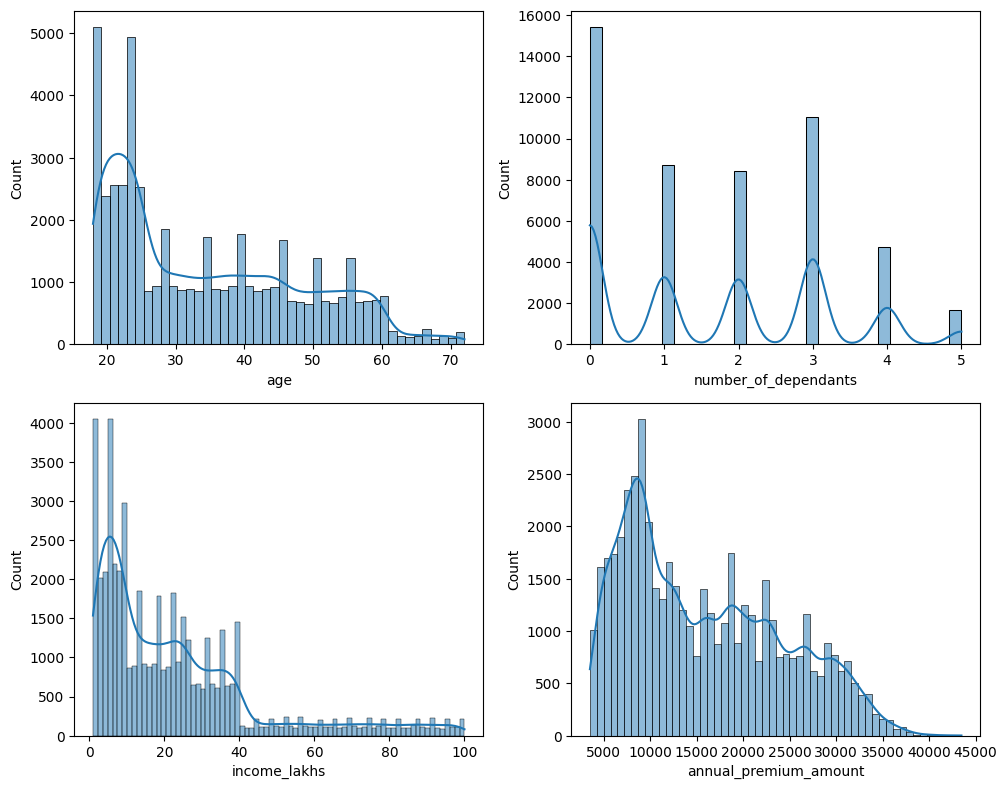

In [238]:
#univariate analysis
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = axs.flatten()
for i,col in enumerate(numeric_features) :
    sns.histplot(df2[col],kde=True,ax=axs[i])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

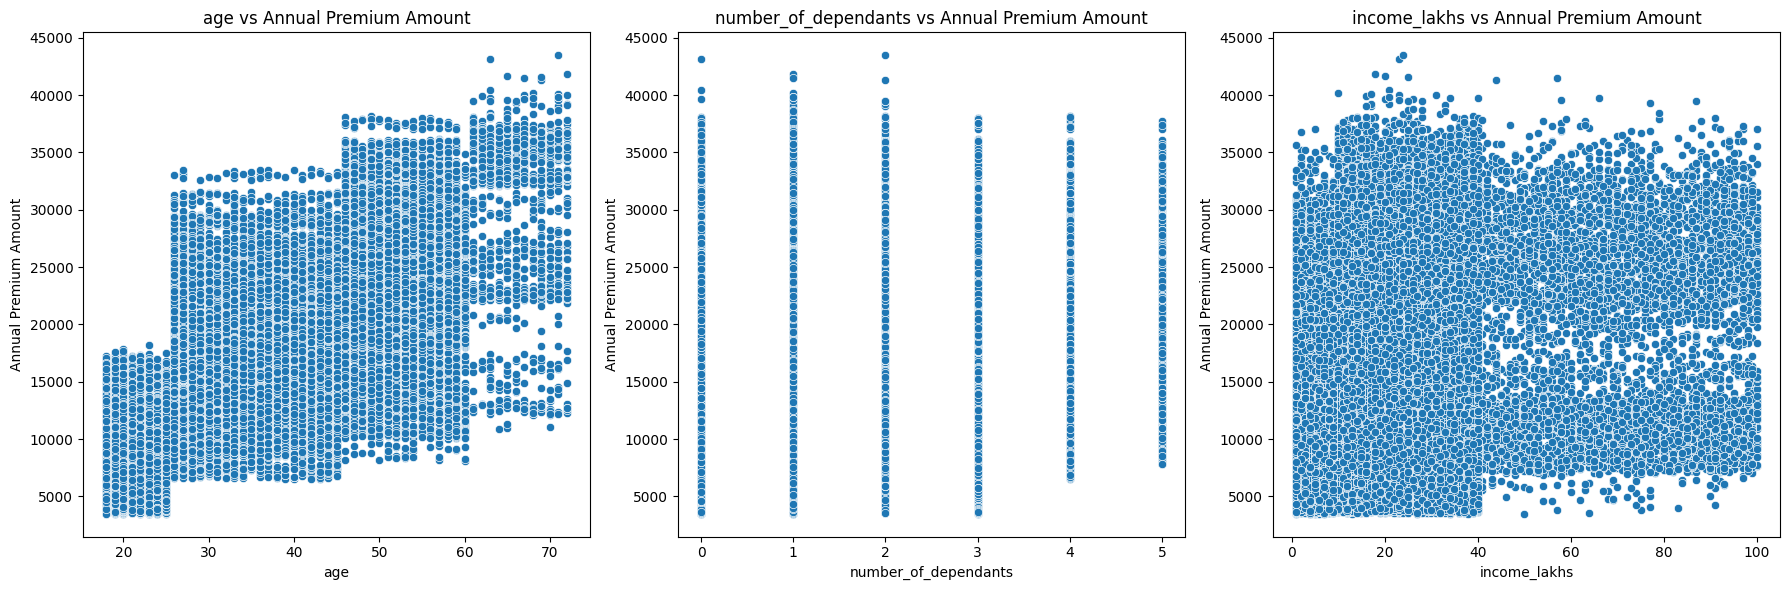

In [239]:
fig, axs = plt.subplots(1, len(numeric_features)-1, figsize=(18, 6))

for ax, col in zip(axs, numeric_features):
    if col != "annual_premium_amount":
        sns.scatterplot(x=df2[col], y=df2["annual_premium_amount"], ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("Annual Premium Amount")
        ax.set_title(f"{col} vs Annual Premium Amount")

plt.tight_layout()
plt.show()


In [240]:
categorical_columns = df2.select_dtypes("object").columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [241]:
for col in categorical_columns :
    print(f"{col} : {df2[col].unique()}")

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [242]:
df2['smoking_status'].replace({
    "Smoking=0" : "No Smoking",
    "Does Not Smoke" : "No Smoking",
    "Not Smoking" : "No Smoking"
},inplace=True)


C:\Users\msart\AppData\Local\Temp\ipykernel_26816\4108123457.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


In [243]:
for col in categorical_columns :
    print(f"{col} : {df2[col].unique()}")

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [244]:
pct = df2["gender"].value_counts()
pct

gender
Male      27431
Female    22477
Name: count, dtype: int64

<Axes: xlabel='gender'>

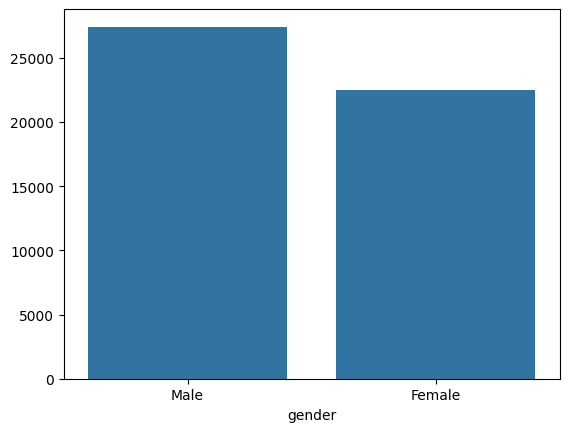

In [245]:
sns.barplot(x=pct.index,y=pct.values)

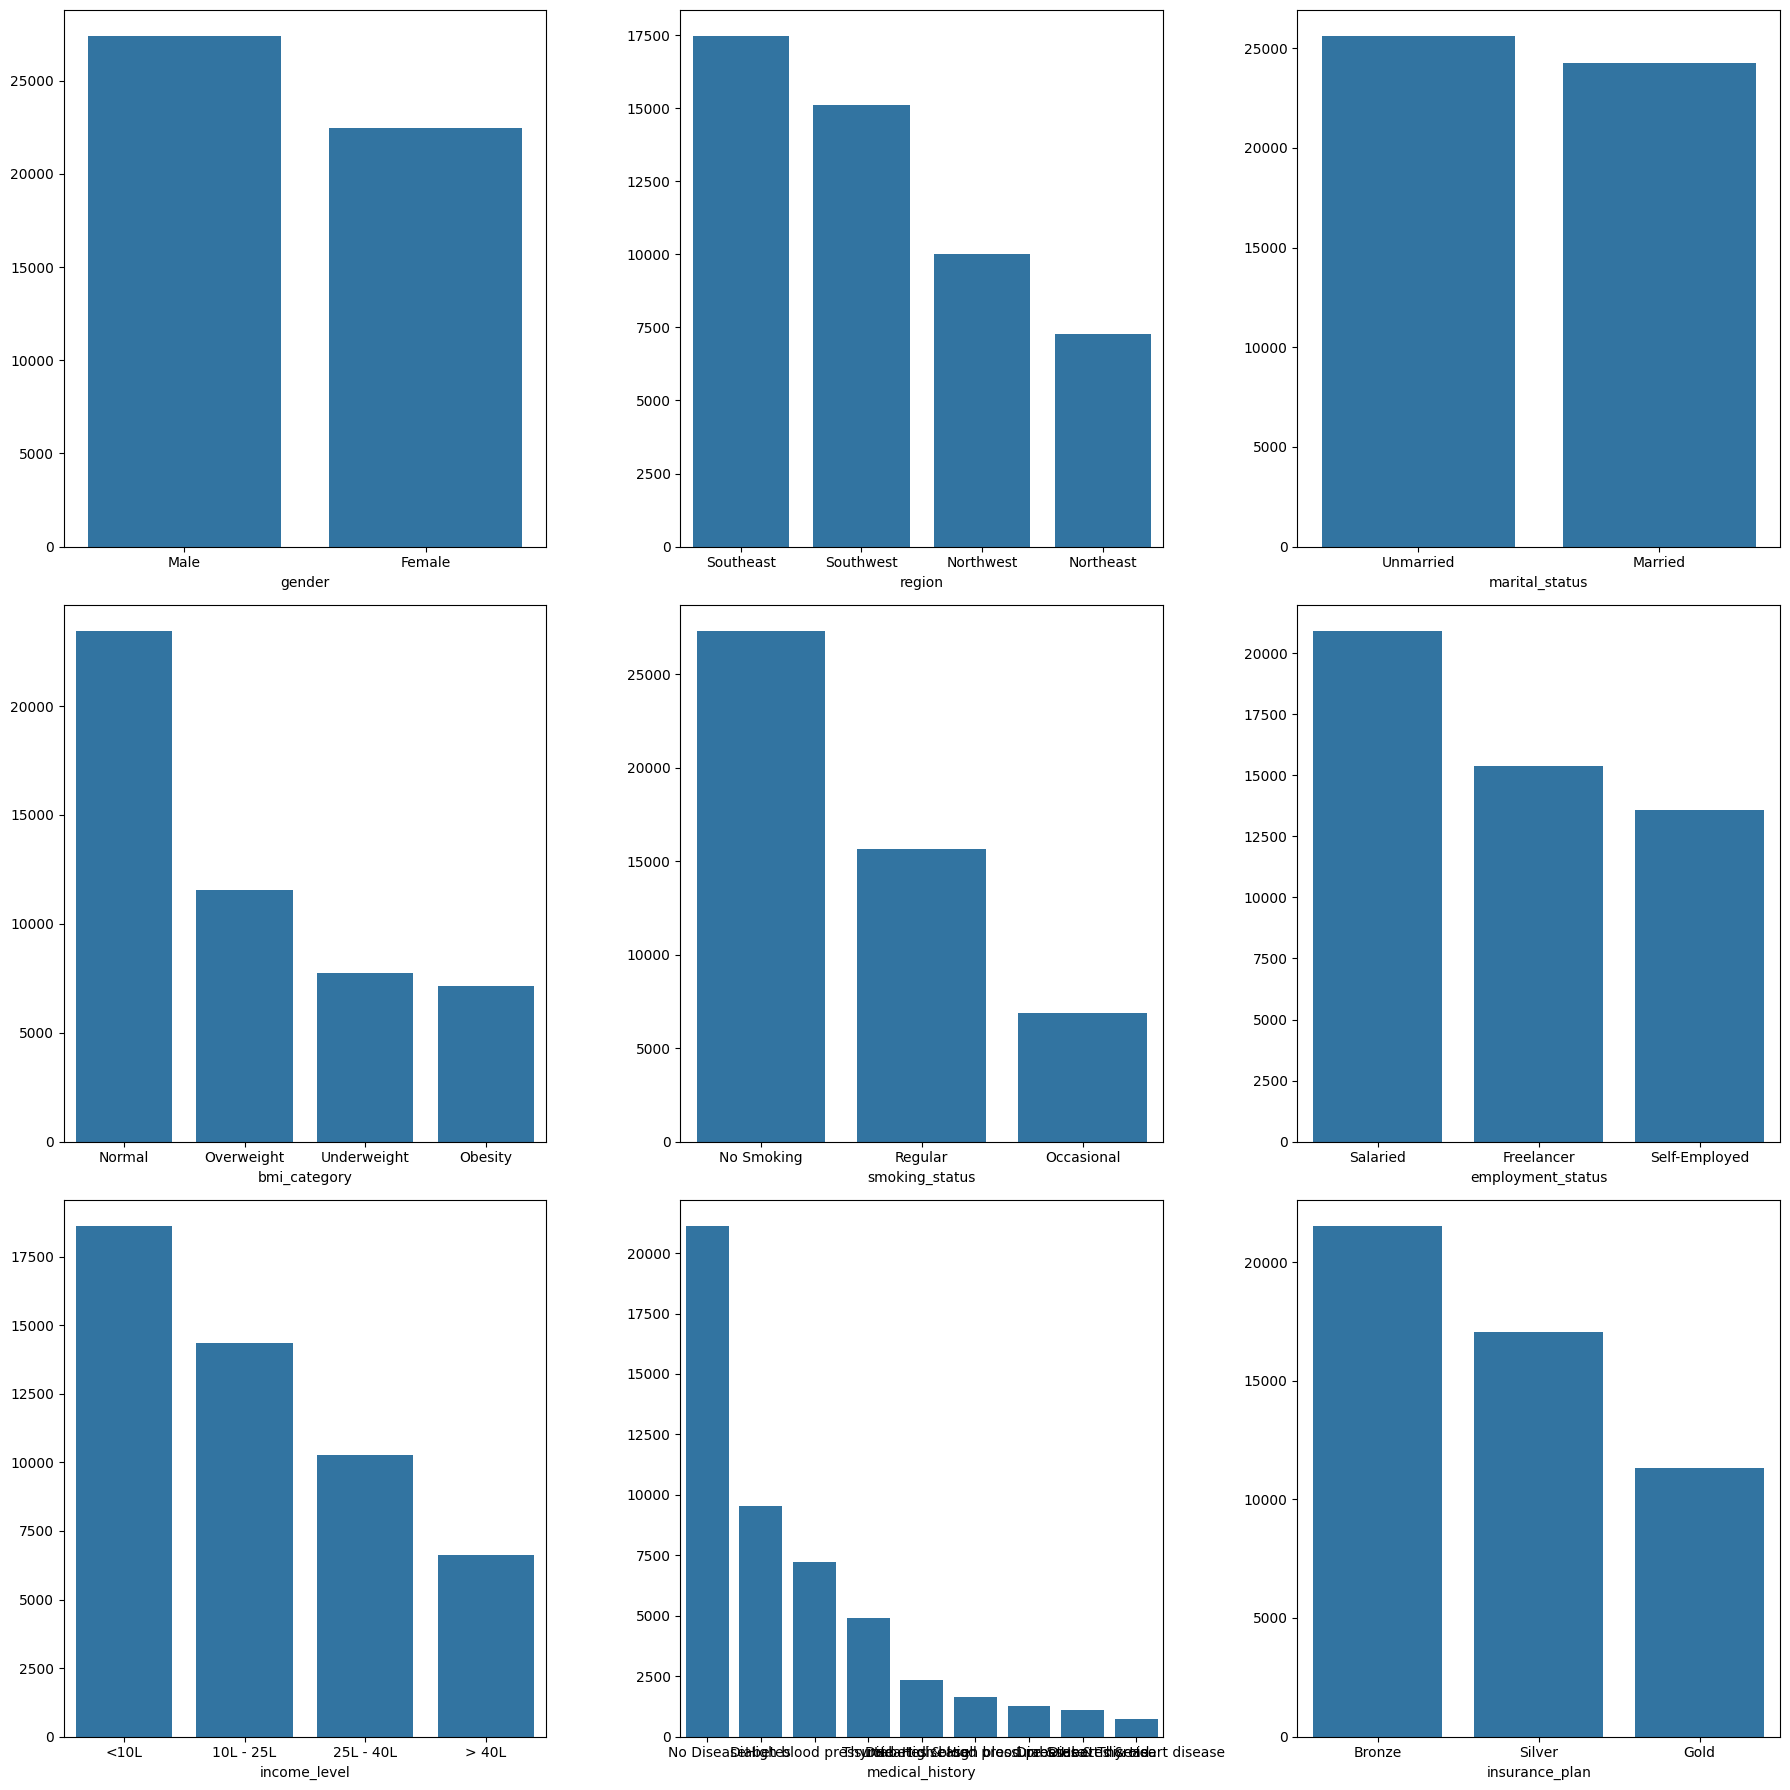

In [246]:
#univariate analysis
fig,axs = plt.subplots(3,3,figsize=(18,18))
axs = axs.flatten()
for i,col in enumerate(categorical_columns) :
    categorical_pct = df2[col].value_counts()
    sns.barplot(x=categorical_pct.index,y=categorical_pct.values,ax=axs[i])
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [247]:
crosstab = pd.crosstab(df2["income_level"],df2["insurance_plan"])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5307,3880,5182
25L - 40L,3683,2840,3750
<10L,12226,931,5486
> 40L,329,3653,2641


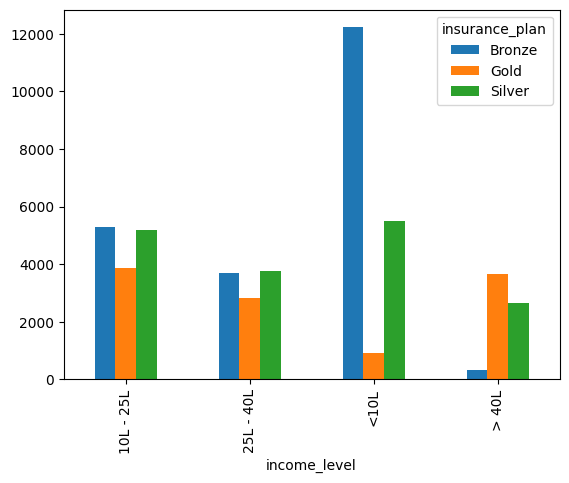

In [248]:
crosstab.plot(kind="bar")
plt.show()

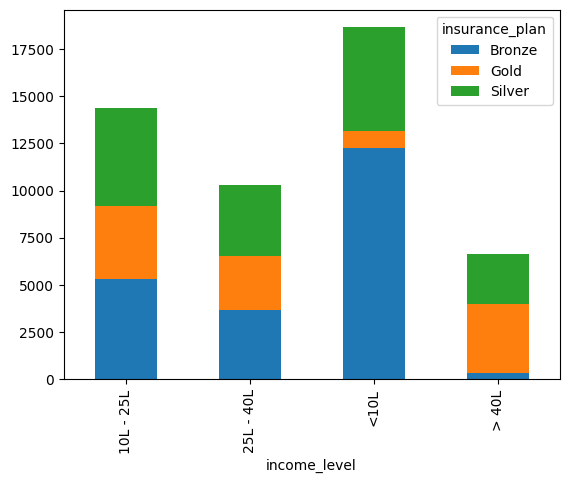

In [249]:
crosstab.plot(kind="bar",stacked = True)
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

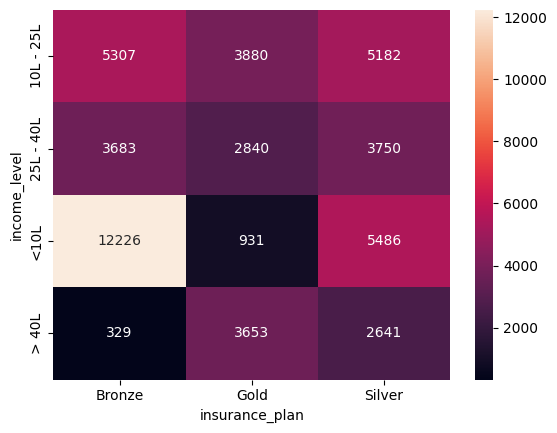

In [250]:
sns.heatmap(crosstab,annot=True,fmt="d")

In [251]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [252]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [253]:
risk_scores = {
    "diabetes" : 6,
    "high blood pressure" : 6,
    "no disease" : 0,
    "thyroid" : 5,
    "heart disease" : 8,
    "none" : 0
}
df2[["disease1","disease2"]] = df2["medical_history"].str.lower().str.strip().str.split(" & ", expand=True).apply(lambda x: x.str.strip()) 

In [254]:
df2.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None


In [255]:
df2['disease1'].fillna("none",inplace=True)
df2['disease2'].fillna("none",inplace=True)
df2.head()

C:\Users\msart\AppData\Local\Temp\ipykernel_26816\2289181906.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna("none",inplace=True)
C:\Users\msart\AppData\Local\Temp\ipykernel_26816\2289181906.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none


In [256]:
df2["total_risk_score"] = 0 

df2["total_risk_score"] = sum(df2[col].map(risk_scores) for col in ["disease1", "disease2"])
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6


In [257]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
df2["total_risk_score"] = minmax.fit_transform(df2[["total_risk_score"]])
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,0.428571


In [258]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [259]:
# we can do label encoding
label_insurance = {
    "Bronze" : 1,
    "Silver" : 2,
    "Gold" : 3
}
df2["insurance_plan"] = df2["insurance_plan"].map(label_insurance)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,0.428571


In [260]:
df2["income_level"].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [261]:
label_income_level = {
    '<10L' : 1, '10L - 25L' :2, '> 40L' : 3, '25L - 40L' :4
}
df2["income_level"] = df2["income_level"].map(label_income_level)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,3,77,No Disease,3,20303,no disease,none,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,2,13365,high blood pressure,none,0.428571


In [262]:
nominal_cols = ["gender","region","marital_status","bmi_category","smoking_status","employment_status"]
df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,3,20303,no disease,none,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,High blood pressure,2,13365,high blood pressure,none,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [263]:
df3.drop(["disease1","disease2","medical_history"],inplace=True,axis=1)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [264]:
cm = df3.corr()
cm

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.415742,0.026606,0.025060,0.496317,0.767569,0.442773,-0.002219,0.000464,0.003305,-0.003424,-0.543104,0.152496,0.153148,-0.115888,0.066596,0.059380,-0.008093,0.314684
number_of_dependants,0.415742,1.000000,0.003396,0.006074,0.256459,0.414691,0.371498,-0.003093,0.001693,0.003620,-0.000339,-0.841717,0.115397,0.110451,-0.093881,0.071762,0.094829,0.067066,0.115930
income_level,0.026606,0.003396,1.000000,0.667679,0.328676,0.218786,0.013994,0.076983,-0.001584,-0.000751,0.006052,-0.009684,-0.006561,0.007643,-0.002392,-0.006054,0.026165,-0.173722,0.154917
income_lakhs,0.025060,0.006074,0.667679,1.000000,0.410753,0.243058,0.009626,0.039126,-0.005192,-0.001250,0.009929,-0.011099,0.000314,0.007150,-0.000740,0.002306,0.010948,-0.100510,0.109759
insurance_plan,0.496317,0.256459,0.328676,0.410753,1.000000,0.834148,0.260932,0.034211,-0.002821,0.004082,-0.000977,-0.316800,0.094698,0.098639,-0.073881,0.037351,0.059587,-0.041582,0.223947
annual_premium_amount,0.767569,0.414691,0.218786,0.243058,0.834148,1.000000,0.519458,0.064470,-0.005078,0.008235,-0.003828,-0.516350,0.249847,0.187103,-0.135289,0.060610,0.198829,-0.005442,0.289438
total_risk_score,0.442773,0.371498,0.013994,0.009626,0.260932,0.519458,1.000000,-0.003754,-0.005627,0.002019,-0.000132,-0.433916,0.101039,0.102556,-0.087996,0.071090,0.093822,0.059511,0.135824
gender_Male,-0.002219,-0.003093,0.076983,0.039126,0.034211,0.064470,-0.003754,1.000000,-0.003287,-0.002988,0.001873,0.003944,-0.031351,0.080588,-0.043000,-0.045618,0.305180,0.005559,0.001055
region_Northwest,0.000464,0.001693,-0.001584,-0.005192,-0.002821,-0.005078,-0.005627,-0.003287,1.000000,-0.368277,-0.330654,-0.001083,-0.002262,0.001194,-0.002017,-0.000669,-0.000255,0.004574,0.000110
region_Southeast,0.003305,0.003620,-0.000751,-0.001250,0.004082,0.008235,0.002019,-0.002988,-0.368277,1.000000,-0.484271,-0.003980,0.006373,0.002511,0.000211,-0.002191,-0.000401,-0.006575,0.003287


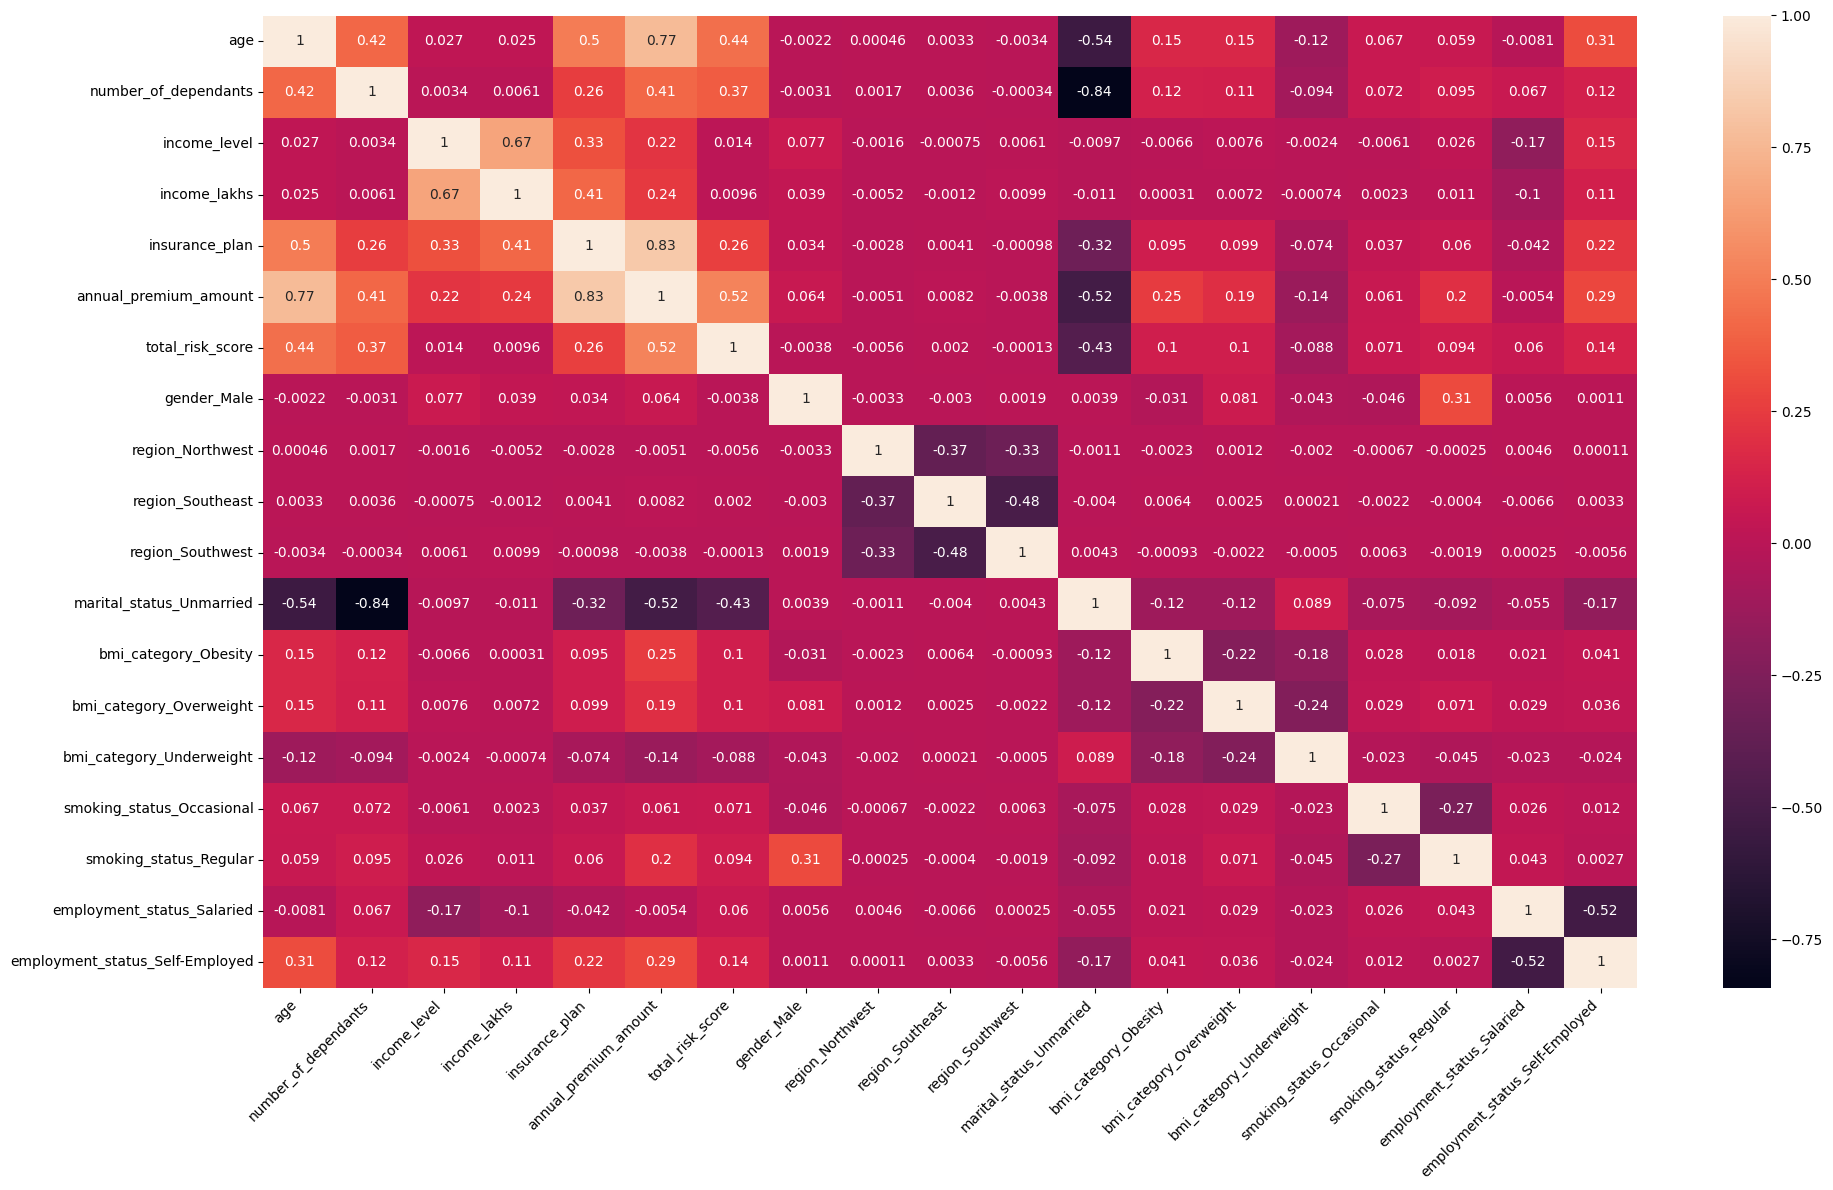

In [265]:
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [266]:
X = df3.drop("annual_premium_amount",axis=1)
y = df3["annual_premium_amount"]
X

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,3,99,2,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,0,4,35,1,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
49996,47,2,3,82,3,0.357143,0,0,1,0,0,0,0,0,0,0,1,0
49997,21,0,4,32,1,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
49998,18,2,2,20,1,0.000000,1,1,0,0,1,0,0,0,0,0,1,0


In [267]:
cols_to_scale = ["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
X[cols_to_scale] = minmax.fit_transform(df3[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.666667,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.666667,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [268]:
def calculate_vif(data) : 
    vif_df = pd.DataFrame()
    vif_df["Column"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df


In [269]:
vif = calculate_vif(X)
vif

,Column,VIF
0,age,4.546828
1,number_of_dependants,4.552788
2,income_level,3.809392
3,income_lakhs,3.940341
4,insurance_plan,3.470028
5,total_risk_score,2.688740
6,gender_Male,2.424683
7,region_Northwest,2.103537
8,region_Southeast,2.923930
9,region_Southwest,2.671921


In [300]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,total_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [301]:
X2 = X.drop(["income_level"],axis=1)
X2.head()

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [302]:
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=10)

In [303]:
print("X Train : ", X_train.shape)
print("X Test : ", X_test.shape)
print("y Train : ", y_train.shape)
print("y Test : ", y_test.shape)

X Train :  (34935, 17)
X Test :  (14973, 17)
y Train :  (34935,)
y Test :  (14973,)


In [304]:
model_r = LinearRegression()
model_r.fit(X_train,y_train)
train_score = model_r.score(X_train,y_train)
test_score= model_r.score(X_test,y_test)
print("Train Score = ",train_score,"\nTest Score = ",test_score)

Train Score =  0.9282143576916762 
Test Score =  0.9280547230217837


In [305]:
model_r.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [306]:
feature_importance = model_r.coef_
coef_df = pd.DataFrame(feature_importance,columns=["Coefficients"],index=X_test.columns)
coef_df

,Coefficients
age,11160.926462
number_of_dependants,-676.443991
income_lakhs,-514.229816
insurance_plan,12557.012936
total_risk_score,4810.357702
gender_Male,168.646662
region_Northwest,-35.719292
region_Southeast,39.965130
region_Southwest,-24.652929
marital_status_Unmarried,-935.760611


In [307]:
coef_df = coef_df.sort_values(by="Coefficients",ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


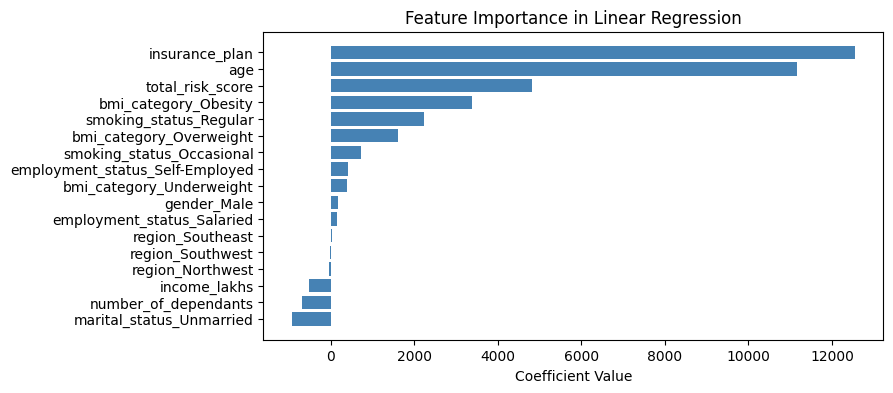

In [308]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df["Coefficients"],color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Linear Regression")
plt.show()

In [309]:
model_rg = Ridge()
model_rg.fit(X_train,y_train)
train_score = model_rg.score(X_train,y_train)
test_score= model_rg.score(X_test,y_test)
print("Train Score = ",train_score,"\nTest Score = ",test_score)

Train Score =  0.9282143198366275 
Test Score =  0.9280541644640345


In [310]:
# lets try diff model

In [311]:
from xgboost import XGBRegressor
model_xg = XGBRegressor()
model_xg.fit(X_train,y_train)
train_score = model_xg.score(X_train,y_train)
test_score= model_xg.score(X_test,y_test)
print("Train Score = ",train_score,"\nTest Score = ",test_score)

Train Score =  0.9860964417457581 
Test Score =  0.9809534549713135


In [312]:
model_xgb = XGBRegressor()
param_grid = {
    "n_estimators" : [20,40,50],
    "learning_rate" : [0.01,0.1,0.2],
    "max_depth" : [3,4,5]
}
random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,y_train)
random_search.best_score_,random_search.best_params_

(np.float64(0.9809474547704061),
 {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1})

In [313]:
best_model = random_search.best_estimator_
best_model.fit(X_train,y_train)
best_model.score(X_train,y_train),best_model.score(X_test,y_test)


(0.9813090562820435, 0.9811745882034302)

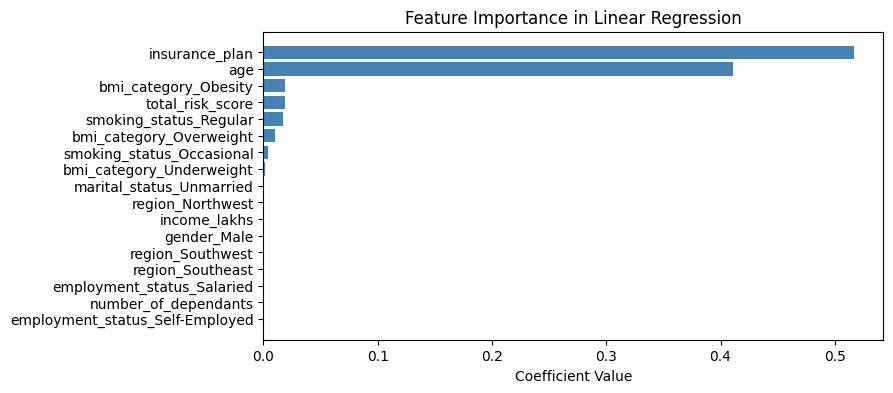

In [314]:
feature_importances = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importances,columns=["Coefficients"],index=X_test.columns)
coef_df = coef_df.sort_values(by="Coefficients",ascending=True)
plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df["Coefficients"],color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Linear Regression")
plt.show()

In [315]:
# feature importancw is not that good visual in XGBoost

In [316]:
# we just cant decide on the basis of r2 score

In [317]:
## we will start error analysis

In [318]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100 / y_test

residuals_df = pd.DataFrame({
    "actual" : y_test,
    "predicted" : y_pred,
    "diff" : residuals,
    "diff_pct" : residuals_pct
})
residuals_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

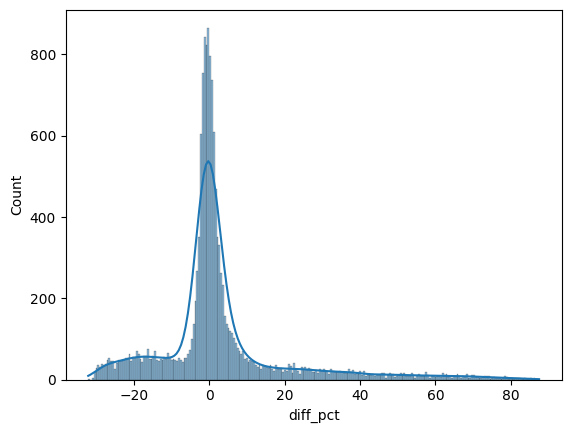

In [319]:
sns.histplot(residuals_df["diff_pct"],kde=True)

In [320]:
# it states that some errors are greater than 60 and 80 pct its not good

In [321]:
extreme_error_threshold = 10
extreme_residuals_df = residuals_df[np.abs(residuals_df["diff_pct"])>extreme_error_threshold]
extreme_residuals_df

,actual,predicted,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822
...,...,...,...,...
8767,8113,6565.852051,-1547.147949,-19.069986
25179,9944,7058.687988,-2885.312012,-29.015608
21592,8332,10615.658203,2283.658203,27.408284
49274,5571,6820.886230,1249.886230,22.435581


In [322]:
residuals_df.shape , extreme_residuals_df.shape

((14973, 4), (4487, 4))

In [323]:
extreme_residuals_df.shape[0]*100 / residuals_df.shape[0] # 30 pct are errors in model

29.967274427302478

In [324]:
X_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [325]:
extreme_residuals_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [326]:
extreme_error_df = X_test.loc[extreme_residuals_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


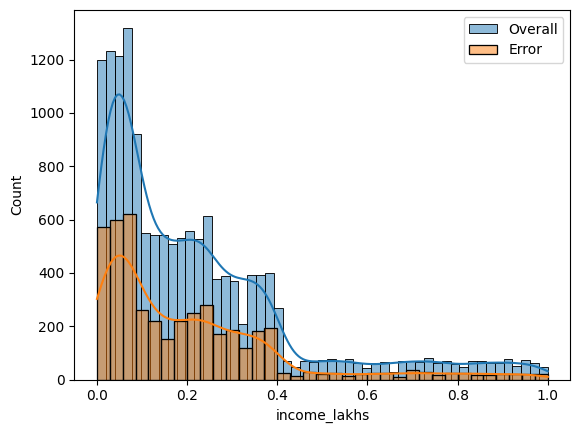

In [329]:
sns.histplot(X_test.income_lakhs,kde = True,label="Overall")
sns.histplot(extreme_error_df.income_lakhs,kde = True,label="Error")
plt.legend()
plt.show()

In [330]:
# both distribution is simililar 

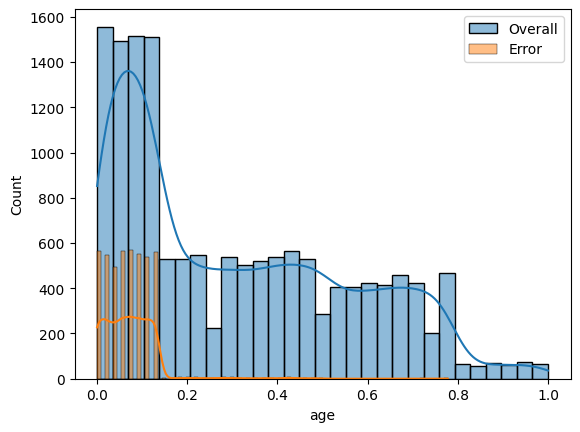

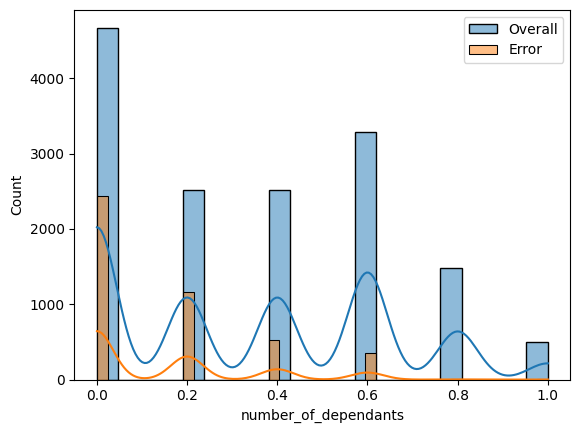

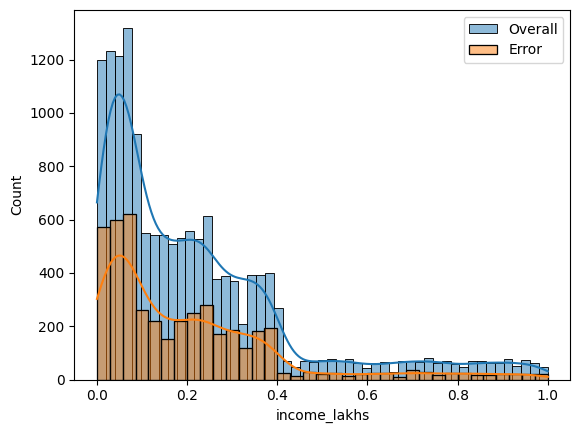

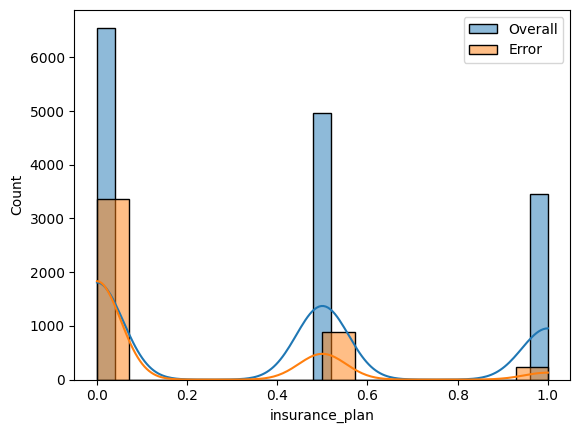

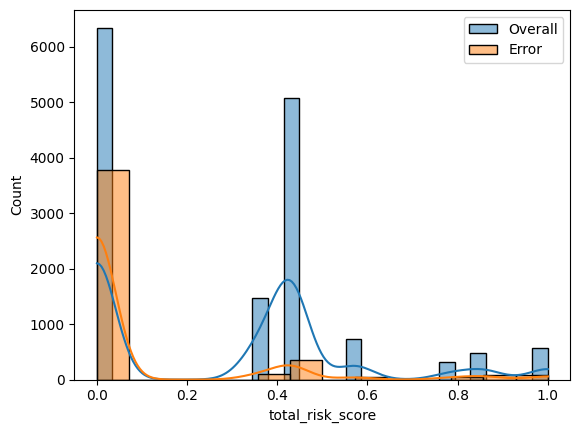

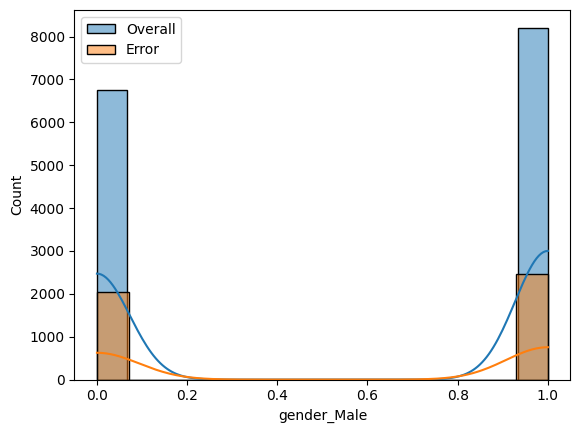

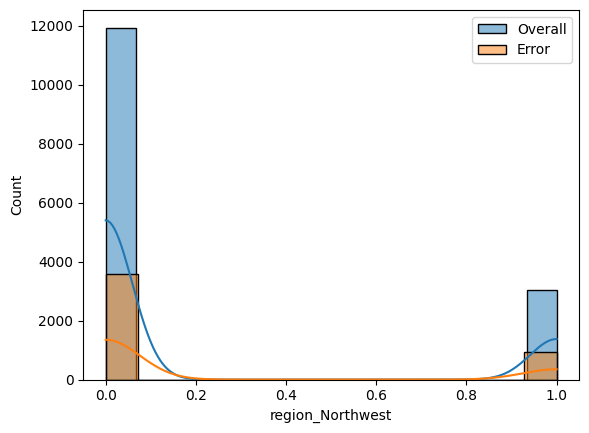

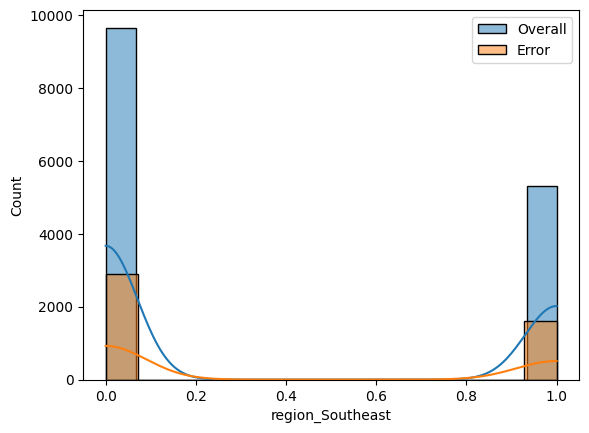

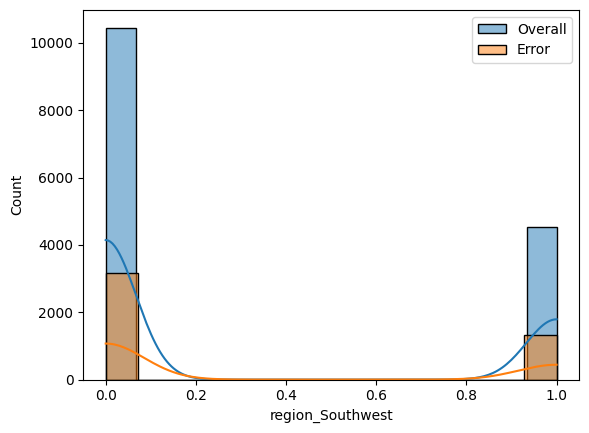

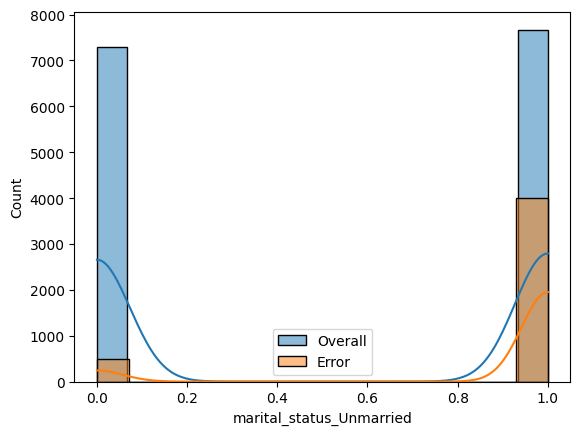

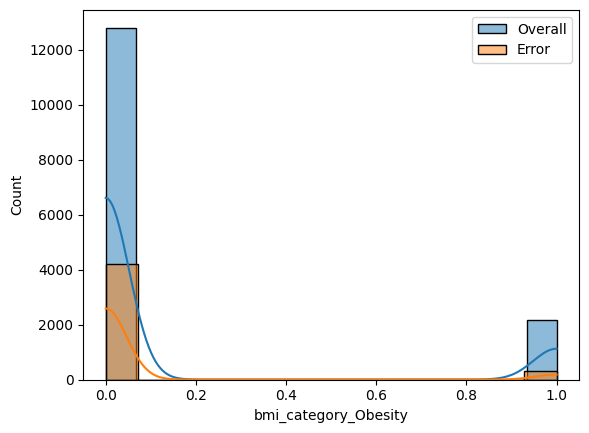

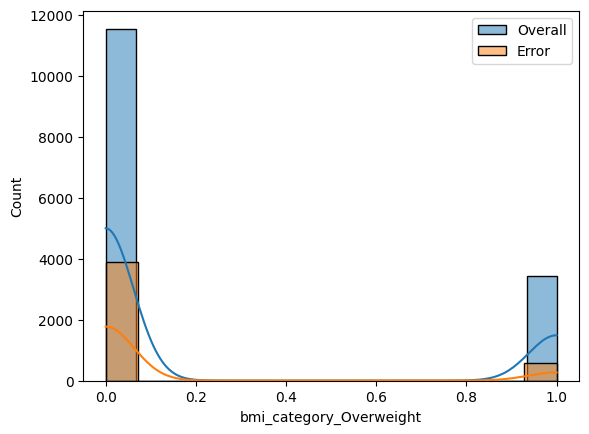

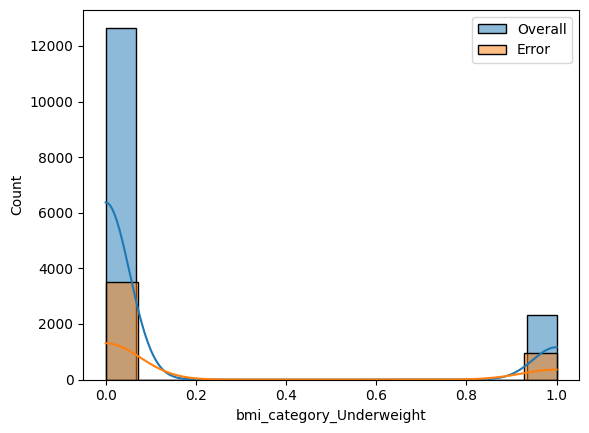

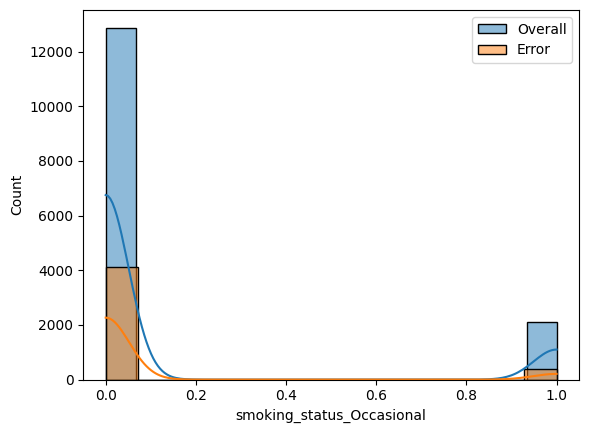

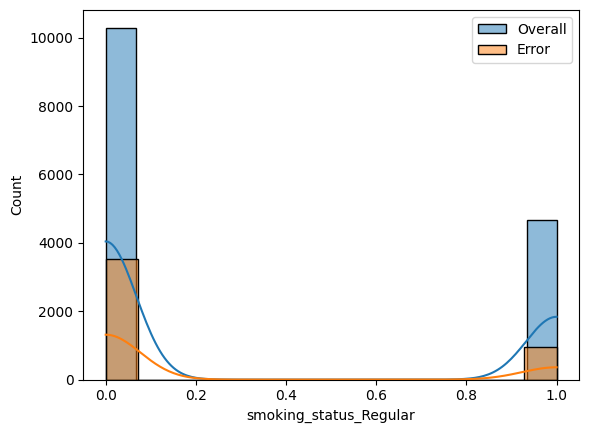

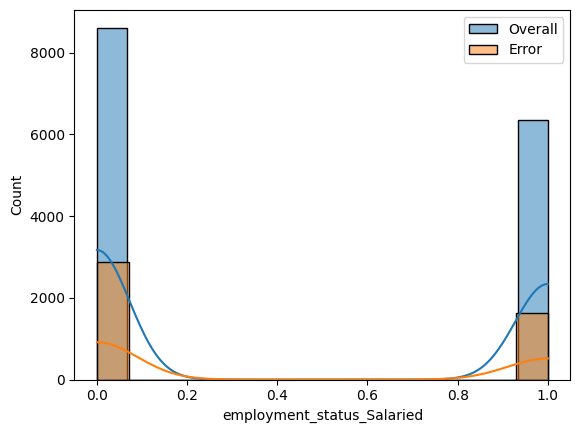

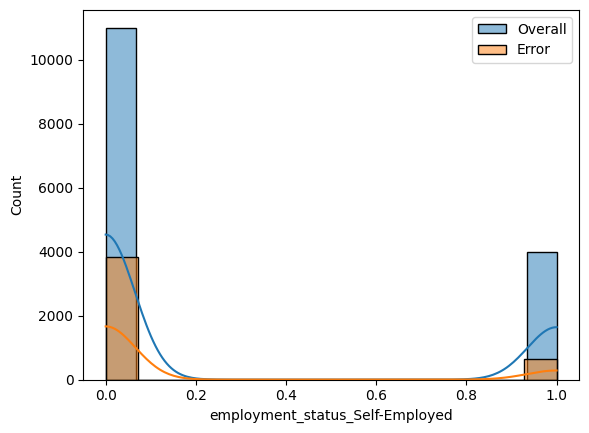

In [334]:
for feature in X_test.columns :
    sns.histplot(X_test[feature],kde = True,label="Overall")
    sns.histplot(extreme_error_df[feature],kde = True,label="Error")
    plt.legend()
    plt.show()

In [335]:
# age column has problem

In [339]:
extreme_error_df["income_level"] = -1
df_reversed= pd.DataFrame(minmax.inverse_transform(extreme_error_df[cols_to_scale]),columns=extreme_error_df[cols_to_scale].columns)
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0
...,...,...,...,...,...
4482,19.0,1.0,-2.0,8.0,1.0
4483,25.0,0.0,-2.0,12.0,1.0
4484,21.0,0.0,-2.0,7.0,2.0
4485,21.0,1.0,-2.0,8.0,1.0


<Axes: xlabel='age', ylabel='Count'>

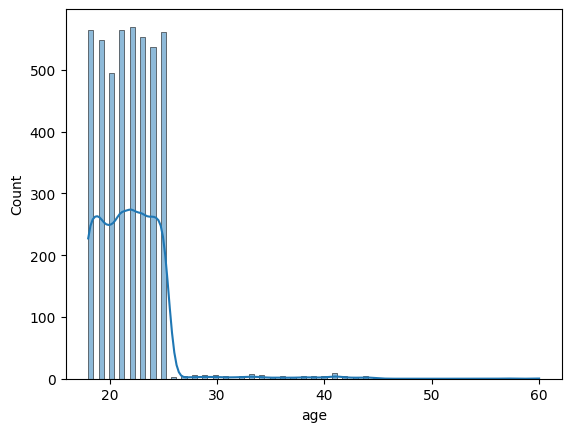

In [340]:
sns.histplot(df_reversed.age,kde=True)

In [345]:
df_reversed["age"].quantile(0.97) # means 95 % of our records are 25 age in extreme error

np.float64(25.0)

In [346]:
# there is some problem we need to analyse further